# Danish-BERT v2 domain-adaptive pretraining (Masked Language Modelling) 🔄

This notebook performs continued pretraining of “Maltehb/danish-bert-botxo” on three political debate corpora (ALL, PLD_QA), including:
1. Environment setup and package installations, CSV loading, train/validation split by debate unit, and dataset/tokenizer preparation.
2. Trainer configuration, MLM fine-tuning across three data subsets, checkpoint saving, loss plotting, perplexity calculation, and model export.

This notebook was run on Google Colab on a Tesla T4 GPU.


In [ ]:
# Uninstall problematic packages (to be safe)
!pip uninstall -y sympy transformers

# Install a known-compatible pair
!pip install sympy==1.11 transformers==4.29.3 datasets -q

## Pretraining largest set (ALL DATA)

In [ ]:
# ✅ Continued Pretraining of Danish BERT on Political Corpus (Masked Language Modeling)
# Google Colab version with device handling, save checkpoints, and Colab Pro GPU use

!pip install transformers datasets -q
!pip install --upgrade sympy

#!pip install sympy==1.11

import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, AutoModelForMaskedLM
)
from sklearn.model_selection import train_test_split
from google.colab import files

# 1. Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# 2. Loading CSV file (without debate-units from the annotated set)
full_path = "/content/ALL_debates_with_turns_and_anon_18_april_debates_wo_labelledrows.csv"
df = pd.read_csv(full_path)

# 3. Preparing text column (single-sequence MLM), using anonymized utterances for MLM pretraining
assert 'Utterance_anon' in df.columns, "Utterance_anon column missing"
df = df.dropna(subset=['Utterance_anon'])
df['text'] = df['Utterance_anon'].astype(str)

# 4. Split by debate_unit to prevent leakage
from sklearn.model_selection import train_test_split

if 'debate_unit_id' in df.columns:

    # 1. Get unique unit IDs
    unit_ids = df['debate_unit_id'].unique()

    # 2. Split those IDs 90/10
    train_ids, val_ids = train_test_split(
        unit_ids, test_size=0.1, random_state=42
    )
    # 3. Assign whole units to train or val
    df_train = df[df['debate_unit_id'].isin(train_ids)]
    df_val   = df[df['debate_unit_id'].isin(val_ids)]

# 5. Build HuggingFace datasets
ds_train = Dataset.from_pandas(df_train[['text']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(df_val[['text']].reset_index(drop=True))

# 6. Tokenization
model_checkpoint = "Maltehb/danish-bert-botxo"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
ds_val   = ds_val.map(tokenize_fn, batched=True, remove_columns=["text"])

# 7. Data collator for MLM
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# 8. Load model & move to GPU
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model.to(device)

# 9. Training arguments
training_args = TrainingArguments(
    output_dir="./danish-bert-mlm",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    push_to_hub=False
)

# 10. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=collator
)

# 11. Train!
trainer.train()

# 12. Save adapted model with a clear name
model.save_pretrained("./danish-bert-adapted-ALL")
tokenizer.save_pretrained("./danish-bert-adapted-ALL")
print("✅ Model saved to ./danish-bert-adapted-ALL")

# Zip & download under the same name
from google.colab import files
!zip -r danish-bert-adapted-ALL.zip danish-bert-adapted-ALL
files.download("danish-bert-adapted-ALL.zip")


✅ Using device: cuda


Map:   0%|          | 0/270426 [00:00<?, ? examples/s]

Map:   0%|          | 0/29953 [00:00<?, ? examples/s]

<ipython-input-2-5188b3ffc97d>:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.421900,1.212640
2,1.241100,1.138791
3,1.170200,1.104492


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


✅ Model saved to ./danish-bert-adapted-ALL
  adding: danish-bert-adapted-ALL/ (stored 0%)
  adding: danish-bert-adapted-ALL/special_tokens_map.json (deflated 80%)
  adding: danish-bert-adapted-ALL/vocab.txt (deflated 55%)
  adding: danish-bert-adapted-ALL/tokenizer_config.json (deflated 75%)
  adding: danish-bert-adapted-ALL/model.safetensors (deflated 7%)
  adding: danish-bert-adapted-ALL/config.json (deflated 53%)
  adding: danish-bert-adapted-ALL/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

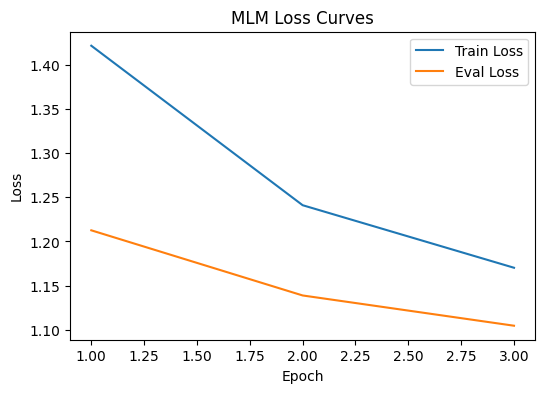

Final Val Loss: nan | Perplexity: nan


,eval_loss,perplexity
0,NaN,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import files

# 1. Extract training history
log_history = pd.DataFrame(trainer.state.log_history)
train_loss  = log_history[log_history['loss'].notna()][['epoch','loss']]
eval_loss   = log_history[log_history['eval_loss'].notna()][['epoch','eval_loss']]

# 2. Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(train_loss['epoch'], train_loss['loss'], label='Train Loss')
plt.plot(eval_loss['epoch'], eval_loss['eval_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLM Loss Curves')
plt.legend()
plt.show()

# 3. Compute final perplexity
final_eval      = trainer.evaluate()
eval_loss_value = final_eval['eval_loss']
perplexity      = math.exp(eval_loss_value)
print(f"Final Val Loss: {eval_loss_value:.4f} | Perplexity: {perplexity:.2f}")

# 4. Build a df and save it
metrics_df = pd.DataFrame([{
    'eval_loss':   eval_loss_value,
    'perplexity':  perplexity
}])

# Display it in-line
display(metrics_df)

# 5. Save to CSV and download to  Mac
metrics_df.to_csv("pretrain_metrics_ALL.csv", index=False)
files.download("pretrain_metrics_ALL.csv")


## Pretraining type-based set PLD_QA

In [ ]:
# ✅ Continued Pretraining of Danish BERT on Political Corpus (Masked Language Modeling)
# Google Colab version with device handling, save checkpoints, and Colab Pro GPU use

!pip install transformers datasets -q
!pip install --upgrade sympy

import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    AutoModelForMaskedLM
)

# 1. Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# 2. Loading CSV file (without debate-units from the annotated set)
# PLD_QA corpus
full_path = "/content/PLD_QA_debates_with_turns_and_anon_18_april_debates_wo_labelledrows.csv"

df = pd.read_csv(full_path)

# 3. Preparing text column (single-sequence MLM), using anonymized utterances for MLM pretraining
assert 'Utterance_anon' in df.columns, "Utterance_anon column missing"
df = df.dropna(subset=['Utterance_anon'])
df['text'] = df['Utterance_anon'].astype(str)

# 4. Split by debate_unit to prevent leakage
from sklearn.model_selection import train_test_split

if 'debate_unit_id' in df.columns:

    # 1. Get unique unit IDs
    unit_ids = df['debate_unit_id'].unique()

    # 2. Split those IDs 90/10
    train_ids, val_ids = train_test_split(
        unit_ids, test_size=0.1, random_state=42
    )
    # 3. Assign whole units to train or val
    df_train = df[df['debate_unit_id'].isin(train_ids)]
    df_val   = df[df['debate_unit_id'].isin(val_ids)]

# 5. Build HuggingFace datasets
ds_train = Dataset.from_pandas(df_train[['text']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(df_val[['text']].reset_index(drop=True))

# 6. Tokenization
model_checkpoint = "Maltehb/danish-bert-botxo"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
ds_val   = ds_val.map(tokenize_fn, batched=True, remove_columns=["text"])

# 7. Data collator for MLM
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# 8. Load model & move to GPU
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model.to(device)

# 9. Training arguments
training_args = TrainingArguments(
    output_dir="./danish-bert-mlm",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    push_to_hub=False
)

# 10. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=collator
)

# 11. Train!
trainer.train()

# 12. Save adapted model with a clear name
model.save_pretrained("./danish-bert-adapted-PLD_QA")
tokenizer.save_pretrained("./danish-bert-adapted-PLD_QA")
print("✅ Model saved to ./danish-bert-adapted-PLD_QA")

# Zip & download under the same name
from google.colab import files
!zip -r danish-bert-adapted-PLD_QA.zip danish-bert-adapted-PLD_QA
files.download("danish-bert-adapted-PLD_QA.zip")


✅ Using device: cuda


Map:   0%|          | 0/52479 [00:00<?, ? examples/s]

Map:   0%|          | 0/5780 [00:00<?, ? examples/s]

<ipython-input-4-96ea9602e961>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.657400,1.418406
2,1.434800,1.336600
3,1.354300,1.291871


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


✅ Model saved to ./danish-bert-adapted-PLD_QA
  adding: danish-bert-adapted-PLD_QA/ (stored 0%)
  adding: danish-bert-adapted-PLD_QA/special_tokens_map.json (deflated 80%)
  adding: danish-bert-adapted-PLD_QA/vocab.txt (deflated 55%)
  adding: danish-bert-adapted-PLD_QA/tokenizer_config.json (deflated 75%)
  adding: danish-bert-adapted-PLD_QA/model.safetensors (deflated 7%)
  adding: danish-bert-adapted-PLD_QA/config.json (deflated 53%)
  adding: danish-bert-adapted-PLD_QA/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

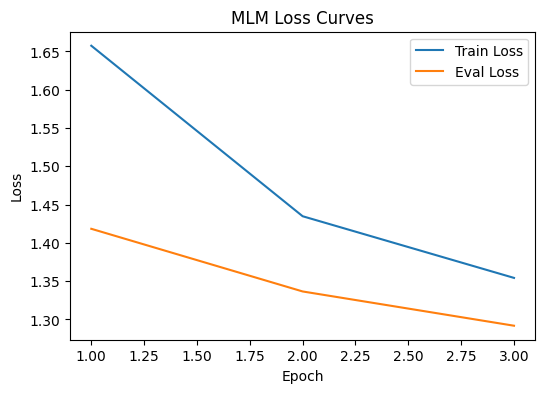

Final Val Loss: 1.3027 | Perplexity: 3.68


,eval_loss,perplexity
0,1.302692,3.679187


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import files

# 1. Extract training history
log_history = pd.DataFrame(trainer.state.log_history)
train_loss  = log_history[log_history['loss'].notna()][['epoch','loss']]
eval_loss   = log_history[log_history['eval_loss'].notna()][['epoch','eval_loss']]

# 2. Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(train_loss['epoch'], train_loss['loss'], label='Train Loss')
plt.plot(eval_loss['epoch'], eval_loss['eval_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLM Loss Curves')
plt.legend()
plt.show()

# 3. Compute final perplexity
final_eval      = trainer.evaluate()
eval_loss_value = final_eval['eval_loss']
perplexity      = math.exp(eval_loss_value)
print(f"Final Val Loss: {eval_loss_value:.4f} | Perplexity: {perplexity:.2f}")

# 4. Build a df and save it
metrics_df = pd.DataFrame([{
    'eval_loss':   eval_loss_value,
    'perplexity':  perplexity
}])

# Display it in-line
display(metrics_df)

# 5. Save to CSV and download to Mac
metrics_df.to_csv("pretrain_metrics_PLD_QA.csv", index=False)
files.download("pretrain_metrics_PLD_QA.csv")
